<a href="https://colab.research.google.com/github/supergoa/Cap4630Repository/blob/master/HW_4/HW4Problem3a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning VGG16 

This is based on section 5.3 *Using a pretrained convnet* of the book *Deep learning with Python* by Francois Chollet. I have made several changes to the code. I use the data that is already provided by Google. I don't download the data from Kaggle as in the deep learning book.

## Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

We will use here the convolutional base of the VGG16 model to extract the features. We will feed these features to a densely connected classifier with dropout. We will fine-tune some layers.

## Download the data

Download the example data, a zip. of 2,000 JPG pictures of cats and dogs and extract it locally in ```/tmp```.



In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-20 21:14:00--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.214.128, 2607:f8b0:4001:c05::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   196MB/s    in 0.3s    

2020-04-20 21:14:00 (196 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Note that the data provided by Google does not have a test set.

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Build network with Xception convolution base and custom densely connected layers

### Load the convolutional base

In [0]:
from keras.applications import Xception

conv_base = Xception(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

Using TensorFlow backend.


83689472/83683744 [==============================] - 1s 0us/step


### Freeze the convolutional base

In [0]:
conv_base.trainable = False

### Concatenate the convolutional base and densely connected layers

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 33,969,193
Trainable params: 13,107,713
Non-trainable params: 20,861,480
_________________________________________________________________


## Train the model end to end with frozen convolutional base

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 26s 260ms/step - loss: 0.4794 - acc: 0.7705 - val_loss: 0.1251 - val_acc: 0.9590
Epoch 2/30
100/100 [==============================] - 17s 174ms/step - loss: 0.3670 - acc: 0.8250 - val_loss: 0.0860 - val_acc: 0.9660
Epoch 3/30
100/100 [==============================] - 17s 171ms/step - loss: 0.3406 - acc: 0.8480 - val_loss: 0.0016 - val_acc: 0.9640
Epoch 4/30
100/100 [==============================] - 17s 175ms/step - loss: 0.3514 - acc: 0.8450 - val_loss: 0.1155 - val_acc: 0.9660
Epoch 5/30
100/100 [==============================] - 18s 180ms/step - loss: 0.3216 - acc: 0.8520 - val_loss: 0.0022 - val_acc: 0.9700
Epoch 6/30
100/100 [==============================] - 18s 181ms/step - loss: 0.3143 - acc: 0.8560 - val_loss: 0.2343 - val_acc: 0.9570
Epoch 7/30
100/100 [==============================] - 17s 172ms/step - loss: 0.3153 - acc: 0.8705 - val_lo

## Display curves of loss and accuracy during training

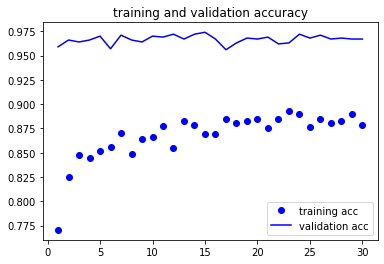

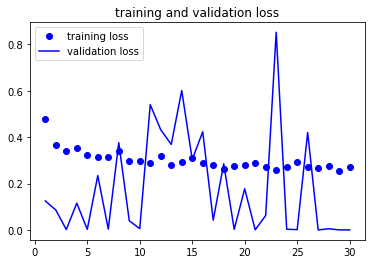

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Fine-tuning

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'conv2d_3':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [11]:
# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 27s 267ms/step - loss: 0.2380 - acc: 0.8985 - val_loss: 0.0544 - val_acc: 0.9560
Epoch 2/100
100/100 [==============================] - 20s 198ms/step - loss: 0.2296 - acc: 0.9050 - val_loss: 0.3166 - val_acc: 0.9510
Epoch 3/100
100/100 [==============================] - 20s 198ms/step - loss: 0.2072 - acc: 0.9165 - val_loss: 0.1545 - val_acc: 0.9360
Epoch 4/100
100/100 [==============================] - 20s 198ms/step - loss: 0.1917 - acc: 0.9270 - val_loss: 0.2437 - val_acc: 0.9520
Epoch 5/100
100/100 [==============================] - 20s 199ms/step - loss: 0.1685 - acc: 0.9315 - val_loss: 0.0172 - val_acc: 0.9540
Epoch 6/100
100/100 [==============================] - 20s 199ms/step - loss: 0.1769 - acc: 0.9260 - val_loss: 0.3982 - val_acc: 0.9540
Epoch 7/100
100/100 [==============================] - 20s 197ms/step - loss: 0.1584 - acc: 0.9390 - val_loss: 0.0787 - val_acc: 0.9460
Epoch 8/100
100/100 [===========================

## Display learning curves during fine-tuning

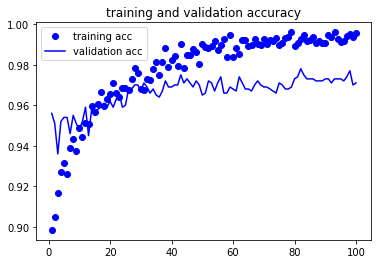

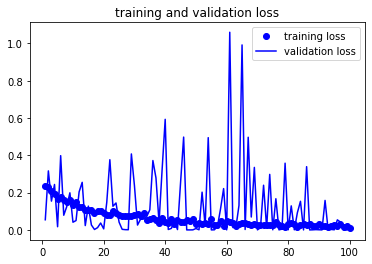

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Print out validation loss and accuracy

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [19]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: [0.05444704741239548, 0.3165731430053711, 0.1544594019651413, 0.24371543526649475, 0.017152579501271248, 0.39824557304382324, 0.0787191390991211, 0.12602007389068604, 0.1990090161561966, 0.041305914521217346, 0.05017770454287529, 0.2038862705230713, 0.25523534417152405, 0.02334754168987274, 0.12752893567085266, 0.02631782367825508, 0.002366463653743267, 0.012181408703327179, 0.037025101482868195, 0.005668177269399166, 0.14924019575119019, 0.3764785826206207, 0.12699167430400848, 0.14448973536491394, 0.04166721925139427, 0.0032795039005577564, 0.0014711536932736635, 0.0010001687332987785, 0.4075353741645813, 0.2369687855243683, 0.02605922520160675, 0.05816838890314102, 0.05888066440820694, 0.07204100489616394, 0.1079375371336937, 0.3721281588077545, 0.2789589762687683, 0.039311207830905914, 0.32364514470100403, 0.5931302309036255, 0.0022750706411898136, 0.008140788413584232, 0.045415572822093964, 0.0018704014364629984, 0.25392600893974304, 0.4978806972503662, 9.97112147

## Save the model

In [0]:
model_fname = 'cats_and_dogs_small_4.h5' 
model.save(model_fname)

In [0]:
from google.colab import files

with open(model_fname, 'r') as f:
  files.download(model_fname)